# Start!

In [ ]:
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import sys
sys.path.append('../')
from utils.tools import *
from utils.model import *
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [2]:
from torch_geometric.data import DataLoader, Batch

def collate_data_list(data_list):
    return Batch.from_data_list(data_list)

def pack_data(nodes_num, test_num, degree=2):
    if degree == 2:
        Times = 50
    if degree == 10:
        Times = 100
        
    edges = int(degree*nodes_num)
    path = f'./data/Series_N{nodes_num}_M{edges}_T{Times}_ind1.pickle'
    with open(path, 'rb') as f:
        objectAij, data= pickle.load(f)

    Dimension = int(data.shape[1]/nodes_num)
    dt = 0.001
    tponits = int(Times/dt)
    data = data.reshape(tponits, nodes_num, Dimension)
    series = data[int(40/0.001):tponits,:,:]

    # use 4-Order diff to fit
    timeseries_ft2 = series[4:,:,:]
    timeseries_ft1 = series[3:-1,:,:]
    timeseries_bt1 = series[1:-3,:,:]
    timeseries_bt2 = series[0:-4,:,:]
    dXdt = (-timeseries_ft2+8*timeseries_ft1-8*timeseries_bt1+timeseries_bt2)/(12*dt)
    timeseries = series[2:-2,:,:]
    print(dXdt.shape==timeseries.shape)

    mapping_data = timeseries
    goal_data = dXdt

    X = torch.as_tensor(np.array(mapping_data).astype('float'))
    y = torch.as_tensor(np.array(goal_data).astype('float'))

    np.random.seed(2042)

    infer_index = get_edge_index(objectAij.T)

    X_test = X.float()
    y_test = y.float()

    # data
    test_idxes = np.random.randint(0, len(X_test), test_num)
    newtestloader = DataLoader(
        [Data(
            X_test[i],
            edge_index=infer_index,
            y=y_test[i]) for i in test_idxes],
        batch_size=len(X_test),
        shuffle=False)

    newtestloader = DataLoader(newtestloader.dataset, batch_size=len(X_test), collate_fn=collate_data_list, shuffle=False)
    return newtestloader

In [4]:
def self_message_error(data_path, Dyn,epc):
    recorded_models = torch.load(data_path+f'recorded_models_e{epc-1}.pt',map_location=device, weights_only=True)
    Dyn.load_state_dict(recorded_models[-1])
    cur_msgs = get_interaction(Dyn, dim=3, msg_dim=1, loader=newtestloader, device=device)
    cur_selfdyn = get_selfDynamics(Dyn, dim=3, loader=newtestloader, device=device)

    bestMe = cur_msgs[['x1','x2','G']]
    x_j = bestMe['x2'].values
    x_i = bestMe['x1'].values
    coup_value = 0.2*(x_j-x_i)
    temp = bestMe.iloc[:,-1].values
    # msg_error = np.abs((coup_value-temp)/coup_value).mean()
    msg_error = 1-(np.corrcoef(coup_value,temp)[0,1])**2

    best_selfDyn = cur_selfdyn
    sx = best_selfDyn['s1'].values
    sx_true = -10*best_selfDyn['x']+10*best_selfDyn['y']
    sy = best_selfDyn['s2'].values
    sy_true = 28*best_selfDyn['x']-best_selfDyn['y']-best_selfDyn['x']*best_selfDyn['z']
    sz = best_selfDyn['s3'].values
    sz_true = -8/3*best_selfDyn['z']+best_selfDyn['x']*best_selfDyn['y']
    self_dim1_error = 1-(np.corrcoef(sx_true,sx)[0,1])**2
    self_dim2_error = 1-(np.corrcoef(sy_true,sy)[0,1])**2
    self_dim3_error = 1-(np.corrcoef(sz_true,sz)[0,1])**2
    best_error = max(self_dim1_error,self_dim2_error,self_dim3_error,msg_error)
    return msg_error, self_dim1_error, self_dim2_error, self_dim3_error,best_error


In [ ]:
n_f = 3
msg_dim = 1
Dimension = 3
dt = 0.001

M = [400,390,380,370,360,350,340,330,320,310,
     300,290,280,270,260,250,240,230,220,210,
     200,190,180,170,160,150,140,130,120,110,
     100,90,80,70,60,50]
ind = [1,2,3,4,5]
hidden = 50
epc = 2800

In [6]:
np.random.seed(20)
ind = [1,2,3,4,5]

In [ ]:
hidden = 50
nodes_num = 5
Mall = [400,390,380,370,360,350,340,330,320,310,300,290,280,270,260,250,240,230,220,210,200,190,180,170,160,150,140,130,120,110,100,90,80,70,60,50]
M = [int(Mall[i]/nodes_num) for i in range(len(Mall))]
Gerror5 = []
F_dim1_error5 = []
F_dim2_error5 = []
F_dim3_error5 = []
F_all_error5 = []
newtestloader = pack_data(nodes_num, 1000)
Dyn = Graph_deriv_NN(n_f, msg_dim, ndim=Dimension, delt_t=dt, hidden=hidden, aggr='add').to(device)
for inx in ind:
    for t in range(len(M)):
        m = M[t]
        data_path = f'knstruc/knStru_Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_self_error = self_message_error(data_path,Dyn,epc)
        Gerror5.append(cur_msg_error)
        F_dim1_error5.append(cur_dim1_error)
        F_dim2_error5.append(cur_dim2_error)
        F_dim3_error5.append(cur_dim3_error)
        F_all_error5.append(cur_self_error)
print(len(Gerror5))

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


180


In [ ]:
hidden = 50
nodes_num = 10
Mall = [400,390,380,370,360,350,340,330,320,310,300,290,280,270,260,250,240,230,220,210,200,190,180,170,160,150,140,130,120,110,100,90,80,70,60,50]
M = [int(Mall[i]/nodes_num) for i in range(len(Mall))]
Gerror10 = []
F_dim1_error10 = []
F_dim2_error10 = []
F_dim3_error10 = []
F_all_error10 = []
newtestloader = pack_data(nodes_num, 1000)
Dyn = Graph_deriv_NN(n_f, msg_dim, ndim=Dimension, delt_t=dt, hidden=hidden, aggr='add').to(device)
for inx in ind:
    for t in range(len(M)):
        m = M[t]
        data_path = f'knstruc/knStru_Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_self_error = self_message_error(data_path,Dyn,epc)
        Gerror10.append(cur_msg_error)
        F_dim1_error10.append(cur_dim1_error)
        F_dim2_error10.append(cur_dim2_error)
        F_dim3_error10.append(cur_dim3_error)
        F_all_error10.append(cur_self_error)
print(len(Gerror10))

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


180


In [ ]:
hidden = 50
nodes_num = 15
Mall = [400,390,380,370,360,350,340,330,320,310,300,290,280,270,260,250,240,230,220,210,200,190,180,170,160,150,140,130,120,110,100,90,80,70,60,50]
M = [int(Mall[i]/nodes_num) for i in range(len(Mall))]
Gerror15 = []
F_dim1_error15 = []
F_dim2_error15 = []
F_dim3_error15 = []
F_all_error15 = []
newtestloader = pack_data(nodes_num, 1000)
Dyn = Graph_deriv_NN(n_f, msg_dim, ndim=Dimension, delt_t=dt, hidden=hidden, aggr='add').to(device)
for inx in ind:
    for t in range(len(M)):
        m = M[t]
        data_path = f'knstruc/knStru_Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_self_error = self_message_error(data_path,Dyn,epc)
        Gerror15.append(cur_msg_error)
        F_dim1_error15.append(cur_dim1_error)
        F_dim2_error15.append(cur_dim2_error)
        F_dim3_error15.append(cur_dim3_error)
        F_all_error15.append(cur_self_error)
print(len(Gerror15))

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


180


In [ ]:
hidden = 50
nodes_num = 20
Mall = [400,380,360,340,320,300,280,260,240,220,200,180,160,140,120,100,80,60,40]
M = [int(Mall[i]/nodes_num) for i in range(len(Mall))]
Gerror20 = []
F_dim1_error20 = []
F_dim2_error20 = []
F_dim3_error20 = []
F_all_error20 = []
newtestloader = pack_data(nodes_num, 1000)
Dyn = Graph_deriv_NN(n_f, msg_dim, ndim=Dimension, delt_t=dt, hidden=hidden, aggr='add').to(device)
for inx in ind:
    for t in range(len(M)):
        m = M[t]
        data_path = f'knstruc/knStru_Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_self_error = self_message_error(data_path,Dyn,epc)
        Gerror20.append(cur_msg_error)
        F_dim1_error20.append(cur_dim1_error)
        F_dim2_error20.append(cur_dim2_error)
        F_dim3_error20.append(cur_dim3_error)
        F_all_error20.append(cur_self_error)
print(len(Gerror20))

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


95


In [ ]:
hidden = 50
nodes_num = 50
M50 = [400,350,300,250,200,150,100,50]
M = [int(M50[i]/nodes_num) for i in range(len(M50))]
epc = 2800
Gerror50 = []
F_dim1_error50 = []
F_dim2_error50 = []
F_dim3_error50 = []
F_all_error50 = []
newtestloader = pack_data(nodes_num, 1000)
Dyn = Graph_deriv_NN(n_f, msg_dim, ndim=Dimension, delt_t=dt, hidden=hidden, aggr='add').to(device)
for inx in ind:
    for t in range(len(M)):
        m = M[t]
        data_path = f'knstruc/knStru_Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_self_error = self_message_error(data_path,Dyn,epc)
        Gerror50.append(cur_msg_error)
        F_dim1_error50.append(cur_dim1_error)
        F_dim2_error50.append(cur_dim2_error)
        F_dim3_error50.append(cur_dim3_error)
        F_all_error50.append(cur_self_error)

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
with open(f'knstruc/error_vs_M_nodes5_10_15_20_50_hidden{hidden}_exp{ind}.pickle', 'wb') as f:
    pickle.dump([Gerror5, F_dim1_error5, F_dim2_error5, F_dim3_error5, F_all_error5,
                 Gerror10, F_dim1_error10, F_dim2_error10, F_dim3_error10, F_all_error10,
                 Gerror15, F_dim1_error15, F_dim2_error15, F_dim3_error15, F_all_error15,
                 Gerror20, F_dim1_error20, F_dim2_error20, F_dim3_error20, F_all_error20,
                 Gerror50, F_dim1_error50, F_dim2_error50, F_dim3_error50, F_all_error50], f)

In [ ]:
def reshape_norm(Matrix):
    exp = len(ind)
    reshape_matrix = np.array(Matrix).reshape(exp,-1)
    return reshape_matrix

In [13]:
values = [5, 10, 15, 20, 50]
name_vars = ['Gerror', 'F_dim1_error', 'F_dim2_error', 'F_dim3_error', 'F_all_error']

results = {}

for value in values:
    for var in name_vars:
        # 动态生成变量名并调用 reshape_norm
        error_var = f'{var}{value}'
        results[error_var] = reshape_norm(globals()[error_var])
        
        # maen and std save in dict 
        results[f'{var}mean{value}'] = np.mean(results[error_var], axis=0)
        results[f'{var}std{value}'] = np.std(results[error_var], axis=0)

In [13]:
results.keys()

dict_keys(['Gerror5', 'Gerrormean5', 'Gerrorstd5', 'F_dim1_error5', 'F_dim1_errormean5', 'F_dim1_errorstd5', 'F_dim2_error5', 'F_dim2_errormean5', 'F_dim2_errorstd5', 'F_dim3_error5', 'F_dim3_errormean5', 'F_dim3_errorstd5', 'F_all_error5', 'F_all_errormean5', 'F_all_errorstd5', 'Gerror10', 'Gerrormean10', 'Gerrorstd10', 'F_dim1_error10', 'F_dim1_errormean10', 'F_dim1_errorstd10', 'F_dim2_error10', 'F_dim2_errormean10', 'F_dim2_errorstd10', 'F_dim3_error10', 'F_dim3_errormean10', 'F_dim3_errorstd10', 'F_all_error10', 'F_all_errormean10', 'F_all_errorstd10', 'Gerror15', 'Gerrormean15', 'Gerrorstd15', 'F_dim1_error15', 'F_dim1_errormean15', 'F_dim1_errorstd15', 'F_dim2_error15', 'F_dim2_errormean15', 'F_dim2_errorstd15', 'F_dim3_error15', 'F_dim3_errormean15', 'F_dim3_errorstd15', 'F_all_error15', 'F_all_errormean15', 'F_all_errorstd15', 'Gerror20', 'Gerrormean20', 'Gerrorstd20', 'F_dim1_error20', 'F_dim1_errormean20', 'F_dim1_errorstd20', 'F_dim2_error20', 'F_dim2_errormean20', 'F_dim2_

In [ ]:
np.save('knstruc/errorRsquare_max.npy',results)

In [ ]:
results = np.load('knstruc/errorRsquare_max.npy',allow_pickle=True).item()

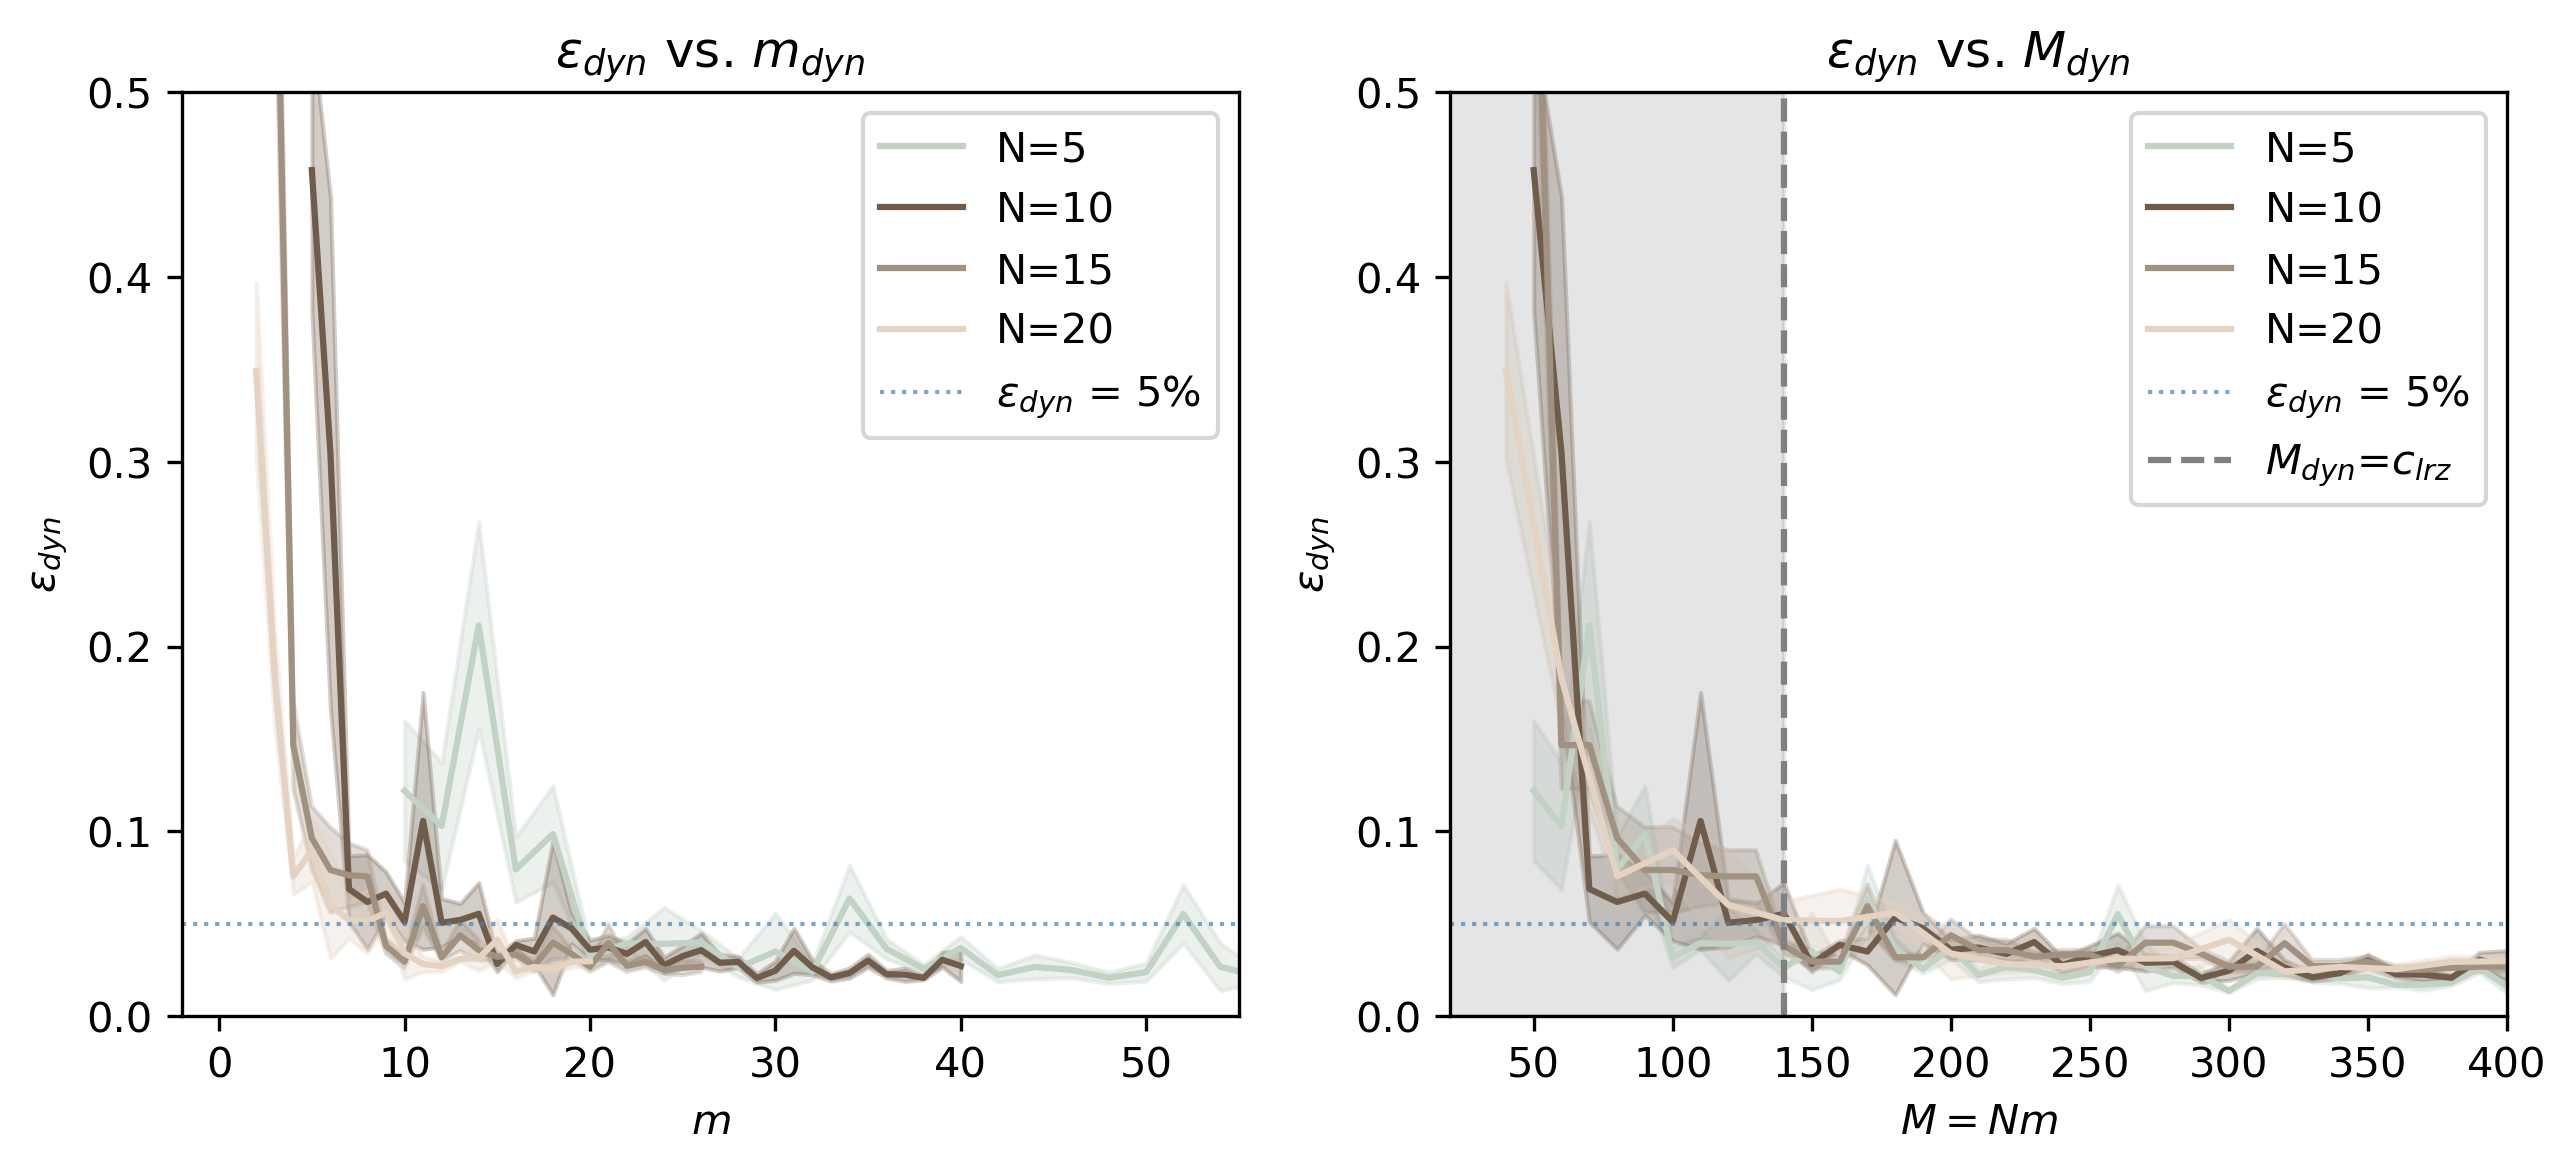

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
fig, (ax2,ax1) = plt.subplots(1,2,figsize = (10,4))

M = [400,390,380,370,360,350,340,330,320,310,
     300,290,280,270,260,250,240,230,220,210,
     200,190,180,170,160,150,140,130,120,110,
     100,90,80,70,60,50]
M20 = [400,380,360,340,320,300,280,260,240,220,200,180,160,140,120,100,80,60,40]
Mall = [M[i] for i in range(len(M))]  
Mall20 = [M20[i] for i in range(len(M20))]
M50 = [400,350,300,250,200,150,100,50]
Mall50 = [M50[i] for i in range(len(M50))]
M100 = [1000,900,800,700,600,500,400,300,200,100]
Mall100 = [M100[i] for i in range(len(M100))]

ax1.plot(Mall,results['F_all_errormean5'][:],color='#C2D2C4',label = 'N=5')
ax1.fill_between(Mall,results['F_all_errormean5']-results['F_all_errorstd5'],results['F_all_errormean5']+results['F_all_errorstd5'],color='#C2D2C4',alpha=0.3)
ax1.plot(Mall,results['F_all_errormean10'][:],color='#705C4B',label = 'N=10')
ax1.fill_between(Mall,results['F_all_errormean10']-results['F_all_errorstd10'],results['F_all_errormean10']+results['F_all_errorstd10'],color='#705C4B',alpha=0.3)
ax1.plot(Mall,results['F_all_errormean15'][:],color='#A19181',label = 'N=15')
ax1.fill_between(Mall,results['F_all_errormean15']-results['F_all_errorstd15'],results['F_all_errormean15']+results['F_all_errorstd15'],color='#A19181',alpha=0.3)
ax1.plot(Mall20,results['F_all_errormean20'][:],color='#E4D2C3',label = 'N=20')
ax1.fill_between(Mall20,results['F_all_errormean20']-results['F_all_errorstd20'],results['F_all_errormean20']+results['F_all_errorstd20'],color='#E4D2C3',alpha=0.3)
# ax1.plot(Mall50,results['F_all_errormean50'][:],color='#917E6C',label = 'N=50')
# ax1.fill_between(Mall50,results['F_all_errormean50']-results['F_all_errorstd50'],results['F_all_errormean50']+results['F_all_errorstd50'],color='#917E6C',alpha=0.3)
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_{dyn}$ = 5%')
ax1.set_ylim(0,0.5)
ax1.set_xlim(20,400)
ax1.axvspan(0, 140, color='gray', alpha=0.2)
ax1.axvline(x=140, color='gray', linestyle='--',label='$M_{dyn}$=$c_{lrz}$')
# ax1.text(0.05, 0.95, 'b', transform=ax1.transAxes, fontsize=12, va='top', ha='left')
ax1.legend()
ax1.set_title('$\epsilon_{dyn}$ vs. $M_{dyn}$')
ax1.set_ylabel('$\epsilon_{dyn}$')
ax1.set_xlabel('$M=Nm$')

M5 = [int(M[i]/5) for i in range(len(M))]
M10 = [int(M[i]/10) for i in range(len(M))]
M15 = [int(M[i]/15) for i in range(len(M))]
M20 = [int(M20[i]/20) for i in range(len(M20))]
M50 = [int(Mall50[i]/50) for i in range(len(Mall50))]
M100 = [int(Mall100[i]/100) for i in range(len(Mall100))]
ax2.plot(M5,results['F_all_errormean5'][:],color='#C2D2C4',label = 'N=5')
ax2.fill_between(M5,results['F_all_errormean5']-results['F_all_errorstd5'],results['F_all_errormean5']+results['F_all_errorstd5'],color='#C2D2C4',alpha=0.3)
ax2.plot(M10,results['F_all_errormean10'][:],color='#705C4B',label = 'N=10')
ax2.fill_between(M10,results['F_all_errormean10']-results['F_all_errorstd10'],results['F_all_errormean10']+results['F_all_errorstd10'],color='#705C4B',alpha=0.3)
ax2.plot(M15,results['F_all_errormean15'][:],color='#A19181',label = 'N=15')
ax2.fill_between(M15,results['F_all_errormean15']-results['F_all_errorstd15'],results['F_all_errormean15']+results['F_all_errorstd15'],color='#A19181',alpha=0.3)
ax2.plot(M20,results['F_all_errormean20'][:],color='#E4D2C3',label = 'N=20')
ax2.fill_between(M20,results['F_all_errormean20']-results['F_all_errorstd20'],results['F_all_errormean20']+results['F_all_errorstd20'],color='#E4D2C3',alpha=0.3)
# ax2.plot(M50,results['F_all_errormean50'][:],color='#917E6C',label = 'N=50')
# ax2.fill_between(M50,results['F_all_errormean50']-results['F_all_errorstd50'],results['F_all_errormean50']+results['F_all_errorstd50'],color='#917E6C',alpha=0.3)
ax2.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_{dyn}$ = 5%')
# ax2.axhline(y=0.05, color='#8D91C0', linestyle='--', linewidth = 1,label='$\epsilon_{dyn}$ = 5%')
ax2.set_ylim(0,0.5)
ax2.set_xlim(-2,55)  
# ax2.text(0.07, 0.95, 'a', transform=ax2.transAxes, fontsize=12, va='top', ha='left')
ax2.legend()
ax2.set_title('$\epsilon_{dyn}$ vs. $m_{dyn}$')
ax2.set_ylabel('$\epsilon_{dyn}$')
ax2.set_xlabel('$m$')

# plt.suptitle('Data of Dynamics prediction with known structure')
# plt.savefig('knstruc/dyn_error2_Rsquare_max_1dim_no50.pdf')

how to estimate the position of curve convergence

In [19]:
dynerror5 = results['F_all_errormean5']
dynerror10 = results['F_all_errormean10']
dynerror15 = results['F_all_errormean15']
dynerror20 = results['F_all_errormean20']
dynerror50 = results['F_all_errormean50']
print(dynerror5.shape)

(36,)


In [ ]:
import numpy as np

def find_convergence_point(x_data, y_data, base=0.05, threshold=0.02, window_size=10):
    """
    check convergence point in curve

    Parameters:
    x_data: x axis data
    y_data: y axis data (the curve to check convergence)
    base: the base value to converge to
    threshold: the acceptable error range
    window_size: the number of consecutive points to consider for convergence

    Returns:
    (bool, float or None): (True, x value) if converged, (False, None) if not converged
    """

    for i in range(len(y_data) - window_size, -1, -1):
        # get the current window of data
        window = y_data[i : i + window_size]
        # check if all points in the window are within the threshold of the base value
        # |value - base| < threshold
        if np.all(np.abs(np.array(window) - base) < threshold):
            # if True, we have found the start of convergence
            # because we are searching backwards, the first point that meets the condition is the start of the convergence interval
            return True, x_data[i]
    # if not found, return False     
    return False, None

converged5, data5 = find_convergence_point(M5, dynerror5, window_size=3)
converged10, data10 = find_convergence_point(M10, dynerror10, window_size=3)
converged15, data15 = find_convergence_point(M15, dynerror15, window_size=3)
converged20, data20 = find_convergence_point(M20, dynerror20, window_size=3)
# converged50, data50 = find_convergence_point(Mall50, dynerror50, window_size=3)

print(f"Convergence points (x-values): {data5*5}, {data10*10}, {data15*15}, {data20*20}")

# filter out None values for non-converged curves before calculating mean and max
valid_data = [d for d in [data5*5, data10*10, data15*15, data20*20] if d is not None]
if valid_data:
    print(f"Mean of converged points: {np.mean(valid_data)}")
    print(f"Max of converged points: {max(valid_data)}")
else:
    print("None of the curves converged.")


Convergence points (x-values): 120, 90, 180, 160
Mean of converged points: 137.5
Max of converged points: 180


In [24]:
def has_converged(xdata, values, threshold=1e-2, base = 0.05):
    valuenew = values[::-1]
    xdatanew = xdata[::-1]
    for i in range(2,len(values)):
        if (valuenew[i]-base)< threshold and (valuenew[i-1]-base)<threshold and (valuenew[i-2]-base) < threshold:
            return True, xdatanew[i]
    return False, None  

converged5, data5 = has_converged(Mall, dynerror5)
converged10, data10 = has_converged(Mall, dynerror10)
converged15, data15 = has_converged(Mall, dynerror15)
converged20, data20 = has_converged(Mall20, dynerror20)
converged50, data50 = has_converged(Mall50, dynerror50)
print(data5, data10, data15, data20)
print(np.mean((data5,data10,data15,data20)))
print(max(data5,data10,data15,data20))

120 140 160 180
150.0
180
